In [1]:
# --- Step 1: Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
import pyodbc

In [2]:
conn_str = (
    "DRIVER={ODBC Driver 18 for SQL Server};"
    "SERVER=localhost;"               # default instance
    "DATABASE=DW_Education;"
    "Trusted_Connection=yes;"
    "TrustServerCertificate=yes;"
)

conn = pyodbc.connect(conn_str)
if conn:
    print("Connected successfully")

Connected successfully


In [3]:
query = """
SELECT
    f.Nb_eleves,
    g.Code_postal AS Code_Postal,
    g.Nom_commune AS Ville,
    g.Libelle_region AS Region,
    e.UAI AS UAI,
    e.Nom_etablissement AS Nom_Etablissement,
    e.Statut_public_prive AS Statut_Etablissement,
    d.Annee,
    d.Mois,
    d.Jour,
    s.Code_Section,
    s.Libelle_Section,
    v.Code_Voie,
    v.Libelle_Voie,
    t.Code_TypeEtab,
    t.Libelle_TypeEtab,
    srv.Code_Service,
    srv.Libelle_Service
FROM dbo.factEtablissement AS f
LEFT JOIN dbo.dim_geographie AS g ON f.Geographie_FK = g.Geographie_PK
LEFT JOIN dbo.dim_etablissment AS e ON f.Etablissment_FK = e.Etablissment_PK
LEFT JOIN dbo.dim_Date AS d ON f.Date_FK = d.Date_PK
LEFT JOIN dbo.dim_Section AS s ON f.Section_FK = s.Section_PK
LEFT JOIN dbo.dim_Voie AS v ON f.Voie_FK = v.Voie_PK
LEFT JOIN dbo.dim_TypeEtablissement AS t ON f.TypeEtab_FK = t.TypeEtab_PK
LEFT JOIN dbo.dim_Service AS srv ON f.Service_FK = srv.Service_PK;

"""
df = pd.read_sql(query, conn)
df.head()


,Nb_eleves,Code_Postal,Ville,Region,UAI,Nom_Etablissement,Statut_Etablissement,Annee,Mois,Jour,Code_Section,Libelle_Section,Code_Voie,Libelle_Voie,Code_TypeEtab,Libelle_TypeEtab,Code_Service,Libelle_Service
0,399.0,61400,Mortagne-au-Perche,Normandie,0611148S,Lycée Jean Monnet,Public,1988.0,9.0,1.0,EUR,Section Européenne,G,Générale,L,Lycée,HEB,Service d'Hébergement
1,399.0,61400,Mortagne-au-Perche,Normandie,0611148S,Lycée Jean Monnet,Public,1988.0,9.0,1.0,EUR,Section Européenne,G,Générale,L,Lycée,RES,Service de Restauration
2,399.0,61400,Mortagne-au-Perche,Normandie,0611148S,Lycée Jean Monnet,Public,1988.0,9.0,1.0,ART,Section Arts,T,Technologique,L,Lycée,HEB,Service d'Hébergement
3,399.0,61400,Mortagne-au-Perche,Normandie,0611148S,Lycée Jean Monnet,Public,1988.0,9.0,1.0,ART,Section Arts,P,Professionnelle,L,Lycée,HEB,Service d'Hébergement
4,399.0,61400,Mortagne-au-Perche,Normandie,0611148S,Lycée Jean Monnet,Public,1988.0,9.0,1.0,ART,Section Arts,G,Générale,L,Lycée,HEB,Service d'Hébergement


In [4]:

# --- Step 3: Clean columns and drop duplicates ---
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.drop_duplicates()
# --- Step 4: Handle NULLs ---
df.replace("NULL", np.nan, inplace=True)
df = df.fillna({
    'Code_Section': 'Unknown',
    'Libelle_Section': 'Unknown',
    'Code_Voie': 'Unknown',
    'Libelle_Voie': 'Unknown',
    'Code_Service': 'Unknown',
    'Libelle_Service': 'Unknown'
})
df['Nb_eleves'] = df['Nb_eleves'].fillna(df['Nb_eleves'].median())
df['Code_Postal'] = df['Code_Postal'].fillna(df['Code_Postal'].mode()[0])

In [5]:
# --- Step 5: Drop high-cardinality or non-informative columns ---
df = df.drop(columns=[
    'Nom_Etablissement', 'UAI', 'Libelle_Section', 'Libelle_Voie',
    'Libelle_TypeEtab', 'Libelle_Service', 'Ville'
], errors='ignore')

# --- Step 6: Choose your target ---
target_col = 'Statut_Etablissement'
X = df.drop(columns=[target_col])
y = df[target_col]

In [6]:
# --- ⚖️ Step 6.5: Undersample the majority class (Public) ---
print("🔹 Balancing dataset by undersampling the 'Public' class...")

# Combine X and y for easier manipulation
df_balanced = pd.concat([X, y], axis=1)

# Count classes
count_private = len(df_balanced[df_balanced[target_col] == "Privé"])
count_public = len(df_balanced[df_balanced[target_col] == "Public"])

print(f"Before undersampling: Privé = {count_private}, Public = {count_public}")

# Randomly sample 'Public' to match 'Privé'
df_public = df_balanced[df_balanced[target_col] == "Public"].sample(
    n=count_private, random_state=42
)
df_private = df_balanced[df_balanced[target_col] == "Privé"]

# Combine balanced data
df_balanced = pd.concat([df_private, df_public]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"After undersampling: {df_balanced[target_col].value_counts().to_dict()}")

🔹 Balancing dataset by undersampling the 'Public' class...
Before undersampling: Privé = 11439, Public = 100251
After undersampling: {'Privé': 11439, 'Public': 11439}


In [7]:

# Reassign X and y
X = df_balanced.drop(columns=[target_col])
y = df_balanced[target_col]

# --- Step 7: Split numeric & categorical features ---
numeric_features = ['Nb_eleves', 'Code_Postal', 'Annee', 'Mois', 'Jour']
categorical_features = [col for col in X.columns if col not in numeric_features]

In [8]:
# --- Step 8: Define preprocessing pipelines ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [9]:
# --- Step 9: Define KNN model pipeline with best parameters ---
knn = KNeighborsClassifier(n_neighbors=7, weights='distance', p=1)
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn)
])

# --- Step 10: Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Step 11: Train the model ---
print("🔹 Training KNN with best parameters...")
pipe.fit(X_train, y_train)
print("✅ Training complete!")

🔹 Training KNN with best parameters...
✅ Training complete!


In [10]:
# --- Step 12: Evaluate the model ---
print("🔹 Evaluating model...")
y_pred = pipe.predict(X_test)

print("✅ Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

🔹 Evaluating model...
✅ Accuracy: 0.942

Classification Report:
               precision    recall  f1-score   support

       Privé       0.91      0.98      0.94      2288
      Public       0.98      0.90      0.94      2288

    accuracy                           0.94      4576
   macro avg       0.94      0.94      0.94      4576
weighted avg       0.94      0.94      0.94      4576



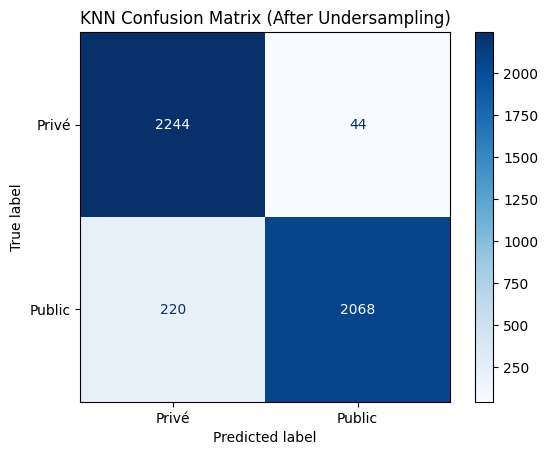

In [11]:
# --- Step 13: Confusion matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.named_steps['knn'].classes_)
disp.plot(cmap='Blues')
plt.title("KNN Confusion Matrix (After Undersampling)")
plt.show()


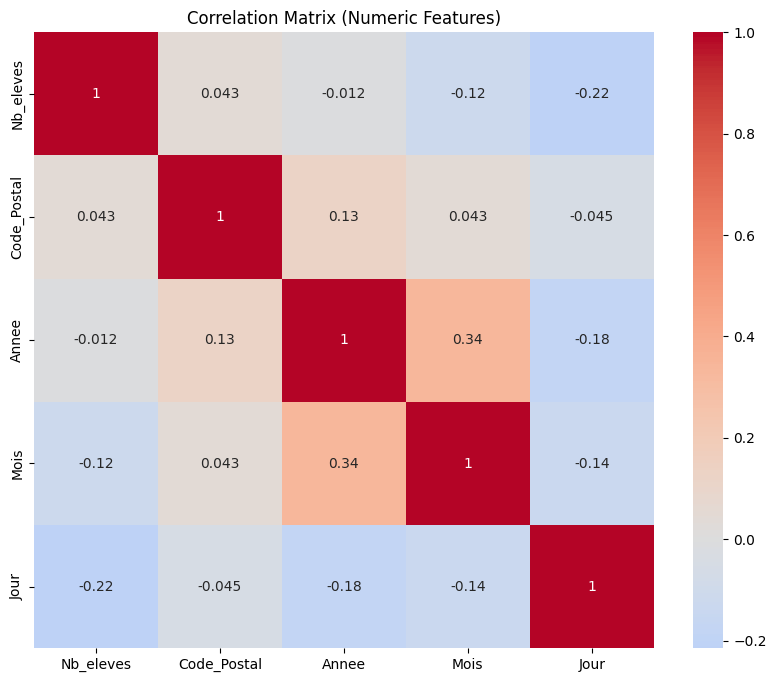

In [12]:
# --- Step 14: Correlation analysis ---
numeric_df = df[numeric_features]
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

In [13]:
import joblib
import pandas as pd

# Save the trained model
joblib.dump(pipe, 'C:/Users/mk/Downloads/knn_model_public_prive.joblib')
print("✅ Model saved as 'knn_model_public_prive.joblib'")

# Create predictions DataFrame with features
predictions_df = X_test.copy()
predictions_df['Actual_Status'] = y_test.reset_index(drop=True)
predictions_df['Predicted_Status'] = y_pred

# Save to CSV
predictions_df.to_csv("C:/Users/mk/Downloads/predictions_knn_prive_public2.csv", index=False)
print("✅ Predictions with features saved as 'predictions_knn_prive_public2.csv'")

# Create confusion matrix in Power BI-friendly format
cm = confusion_matrix(y_test, y_pred)
class_labels = pipe.named_steps['knn'].classes_

# Convert confusion matrix to long format
cm_df = pd.DataFrame({
    'Actual': [class_labels[i] for i in range(len(class_labels)) for j in range(len(class_labels))],
    'Predicted': [class_labels[j] for i in range(len(class_labels)) for j in range(len(class_labels))],
    'Count': cm.flatten()
})

# Save confusion matrix
cm_df.to_csv("C:/Users/mk/Downloads/confusion_matrix_knn.csv", index=False)
print("✅ Confusion matrix saved as 'confusion_matrix_knn.csv'")
print("\nConfusion Matrix Preview:")
print(cm_df)

# To load the model later:
# loaded_model = joblib.load('knn_model.joblib')
# new_predictions = loaded_model.predict(new_data)

✅ Model saved as 'knn_model_public_prive.joblib'
✅ Predictions with features saved as 'predictions_knn_prive_public2.csv'
✅ Confusion matrix saved as 'confusion_matrix_knn.csv'

Confusion Matrix Preview:
   Actual Predicted  Count
0   Privé     Privé   2244
1   Privé    Public     44
2  Public     Privé    220
3  Public    Public   2068


In [14]:
# --- Step 12: Evaluate the model ---
print("🔹 Evaluating model...")
y_pred = pipe.predict(X_test)

print("✅ Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Create classification report DataFrame for Power BI
from sklearn.metrics import precision_recall_fscore_support

# Get metrics for each class
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
class_labels = pipe.named_steps['knn'].classes_

# Create classification report DataFrame
classification_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1_Score': f1,
    'Support': support
})

# Add overall accuracy row
accuracy = accuracy_score(y_test, y_pred)
overall_row = pd.DataFrame({
    'Class': ['Overall'],
    'Precision': [accuracy],
    'Recall': [accuracy],
    'F1_Score': [accuracy],
    'Support': [len(y_test)]
})

classification_df = pd.concat([classification_df, overall_row], ignore_index=True)

# Save to CSV
classification_df.to_csv("C:/Users/mk/Downloads/classification_report_knn_public_prive_3.csv", index=False)
print("\n✅ Classification report saved as 'classification_report_knn_public_prive_3.csv'")
print("\nClassification Report Preview:")
print(classification_df)

🔹 Evaluating model...


✅ Accuracy: 0.942

Classification Report:
               precision    recall  f1-score   support

       Privé       0.91      0.98      0.94      2288
      Public       0.98      0.90      0.94      2288

    accuracy                           0.94      4576
   macro avg       0.94      0.94      0.94      4576
weighted avg       0.94      0.94      0.94      4576


✅ Classification report saved as 'classification_report_knn_public_prive_3.csv'

Classification Report Preview:
     Class  Precision    Recall  F1_Score  Support
0    Privé   0.910714  0.980769  0.944444     2288
1   Public   0.979167  0.903846  0.940000     2288
2  Overall   0.942308  0.942308  0.942308     4576


In [15]:
import pickle 
# Save the trained model
with open(r'C:/Users/mk/Downloads/knn_model_public_prive.pkl', 'wb') as f:
    pickle.dump(pipe, f)